In [1]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

# Define plotting defaults: colour palette and font size
pal = ['k', 'm', 'b', 'c', 'darkorange', 'crimson' ]
fs = 10

# Define helper functions

In [2]:
def print_question_text(col_name: str) -> None:
    '''Print question text for specified column name from schema dataframe
    
    Args:
    col_name: str. Name of column in schema dataframe
    
    Returns:
    None
    '''
    try:
        question_text = schema.loc[schema.Column==col_name,'QuestionText'].values[0]
        print(f'{col_name}: {question_text}\n')
    except:
        print('Column name does not exist.\n')
        

def print_null_val_percentage(df: pd.DataFrame, col_name:str) -> None:
    '''Print percentage of rows in specified column of df that are null
    
    Args:
    df: DataFrame.  DataFrame of data to be reviewed
    col_name: str.  Name of column within df to calculate percentage of null values for
    
    Returns:
    None
    '''
    try:
        null_pct = round(100 * df[col_name].isnull().sum() / df.shape[0], 2)
        print(f'{null_pct}% of the {col_name} column is Null.')
    except:
        print('Invalid arguments provided.')


def split_col_vals(df: pd.DataFrame, col_name:str) -> tuple([pd.DataFrame, list]):    
    '''Split multiple values within a DataFrame column into multiple value-specific 
    columns in the DataFrame
    
    Value-specific columns are populated with a 1 where the column is relevant to the 
    row and a 0 where it isn't.  The DataFrame with the additional value-specific 
    columns is returned along with a list of the value-specific column names added to 
    the DataFrame.
    
    Args:
    df: DataFrame.  A DataFrame of data with a column (col_name) to be split into value-specific  
    columns
    col_name: str. Name of the column within the DataFrame df to be split
    
    Returns:
    DataFrame: The DataFrame with additional value-specific columns populated with 1 or 0
    list: A list of value-specific column names added to the DataFrame
    '''
    # Create a list of unique values within col_name
    unique_vals = []
    for idx, row in df.iterrows():
        # Split col_name into a list of values for each row
        for val in row[col_name].split(";"):
            # Add column to df for each unique value within col_name and 
            # assign 1 where applicable to the row 
            df.loc[idx, val] = 1
            if val not in unique_vals:
                unique_vals.append(val)

    # Fill NaNs in unique_vals columns with 0   
    df[unique_vals] = df[unique_vals].fillna(0)
    
    return df, unique_vals

def return_series_barh(ds:pd.Series, title_text:str):
    '''Create a formatted and titled horizontal bar chart of a Pandas Series and return 
    the fig and ax objects for additional configuration
    
    Args:
    ds: Series. Pandas Series to be used for horizontal bar chart
    title_text: str. Text string to be used for chart title
    
    Returns:
    fig: figure object. Figure object for formatted horizontal bar chart
    ax: axis object. Axis object for formatted horizontal bar chart
    '''
    
    fig, ax = plt.subplots(figsize=(8,12))
    ax.barh(ds.index, ds, color=pal)
    
    # Configure axes and layout
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.4)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.margins(y=0.02)
    ax.set_xlabel('Percentage (%)', fontsize=fs+1)
    ax.set_title(title_text, fontsize=fs+2)
    
    # Annotate labels alongisde horizontal bars in chart
    for i, v in enumerate(ds):
        ax.text(v+0.5, i + .15, f'{str(v)}%', color='k', fontsize=fs-1)

    return fig, ax

def return_line_plot(df: pd.DataFrame, title_text: str, col_list:list):
    '''Create a formatted and titled line plot of a DataFrame's columns, with the 
    DataFrame index as the x-axis and return the fif and ax objects for additional 
    configuration
    
    Individual line plots are labelled with the column name.
    
    Args:
    df: DataFrame. A DataFrame of data for line plot
    title_text: str. A string that will be used as the title of the plot
    col_list: list: A list of df columns to plot 
    
    Returns:
    fig: figure object. Figure object for formatted line chart
    ax: axis object. Axis object for formatted line chart
    '''
    
    fig,ax = plt.subplots(figsize=(9,7))
    
    # Add a line plot for each specified column in df
    for (ind, col) in enumerate(df[col_list]):
        ax.plot(df.index, df.loc[:,col], label=col, c=pal[ind], lw=1.2, marker='o', ms=6)

    # Configure axes and layout
    ax.set_ylabel('Percentage (%)', fontsize=fs+1)
    ax.set_title(title_text, fontsize=fs+2)
    ax.grid(alpha=0.4)
    ax.legend(loc=[1.05,0.5], frameon=False)
    
    return fig, ax

def comp_ctry_boxplot(df: pd.DataFrame) -> None:    
    '''Generate a boxplot and swarmplot of the Pandas DataFrame df, which contains 
    the converted compensation of Data Scientists and their country of residence
    
    Args:
    df: DataFrame.  A DataFrame of the residence country and ConvertedComp of 
    selected survey respondents.
    
    Returns: 
    None
    '''
    
    fig, ax = plt.subplots(figsize=(11,9))
    
    # Define df columns for plot
    y_axis = 'ConvertedComp'
    x_axis = 'Country'
    
    # Plot boxplot for each country
    ax = sns.boxplot(x=x_axis, y=y_axis, data=df, linewidth=1.2, fliersize=0, palette=pal, 
                     medianprops = dict(linewidth=1.5, color='w'), 
                     boxprops = dict(linewidth=1.5, edgecolor='k'),
                     whiskerprops=dict(linewidth=1.5, color='k'))
    
    # Overlay swarm plot on box plot
    ax = sns.swarmplot(x=x_axis, y=y_axis, data=df, size=2, color='grey')
    
    # Configure axes and layout
    ax.tick_params(axis='both', which='major', labelsize=fs+1)
    ax.set_ylabel('Converted Compensation ($USD)', fontsize=fs+2)
    ax.set_xlabel('Country', fontsize=fs+2)
    ax.set_title(f'Converted Compensation of {len(ds_comp_ctry_filtered):,} \'{ds_role_title}\' \n ' \
                 f'respondents vs. country of residence (outliers removed with the Tukey Method)', fontsize=fs+2)
    ax.set_xticklabels(labels=df.Country.unique(), rotation=90)
    ax.grid(alpha=0.4) ;
    
    
def return_adjacent_barh(df: pd.DataFrame, col_left:str, col_right:str, highlight_text:bool=False):
    '''Generate a formatted side-by-side horizontal bar chart of 2 specified columns within a 
    Pandas Dataframe and return the fig and ax objects for additional configuration
    
    Args:
    df: DataFrame. Pandas DataFrame to be used for horizontal bar chart
    col_left: str. Name of df column to be positioned on left side of back-to-back chart
    col_right: str. Name of df column to be positioned on right side of back-to-back chart
    highlight_text: boolean.  If True, highlight specific label in y-axis
        
    Returns:
    fig: figure object. Figure object for formatted horizontal bar chart
    ax: axis object. Axis object for formatted horizontal bar chart
    '''
    
    # Generate side-by-side subplot with default size
    fig, ax = plt.subplots(figsize=(13,12), ncols=2, sharey=True)

    # Plot col_left on left side of subplot
    y = np.arange(len(df))
    ax[0].barh(y, df[col_left], color=pal)
    ax[0].invert_yaxis()
    ax[0].invert_xaxis()
    ax[0].grid(axis='x', alpha=0.4)
    ax[0].tick_params(axis='both', which='major', labelsize=fs)
    ax[0].margins(y=0.02)

    # Annotate percentage figures on plot
    for (i, v) in enumerate(df[col_left]):
        ax[0].text(v+6.5, i+0.15, f'{str(v)}%', color='k', fontsize=fs-1)

    # Generate y-axis labels to appear between subplots
    ax[0].yaxis.tick_right()
    ax[0].set(yticks=y, yticklabels=[])
    for (yloc, y_axis_label) in enumerate(df.index):
        # Highlighted selected label if option specified
        if (highlight_text) & (yloc==11):
            ax[0].annotate(f'{y_axis_label} *', (0.5, yloc), xycoords=('figure fraction', 'data'),
                           ha='center', va='center', fontsize=fs, color='crimson')
        else:            
            ax[0].annotate(y_axis_label, (0.5, yloc), xycoords=('figure fraction', 'data'),
                           ha='center', va='center', fontsize=fs, color='k')

    # Plot col_right on right side of subplot
    ax[1].barh(y, df[col_right], color=pal)
    ax[1].grid(axis='x', alpha=0.4)
    ax[1].tick_params(axis='both', which='major', labelsize=fs)
    ax[1].margins(y=0.02)

    # Annotate percentage figures on plot
    for i, v in enumerate(df[col_right]):
        ax[1].text(v+5, i+0.15, f'{str(v)}', color='k', fontsize=fs-2)

    # Configure default figure layout
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.3) 

    return fig, ax

# Load survey data and inspect survey questions of interest

In [3]:
# Read in survey data and schema
survey = pd.read_csv('survey_results_public.csv')
schema = pd.read_csv('survey_results_schema.csv')

In [4]:
# Call function to Display question text for survey questions of interest
question_list = ['DevType', 'JobSat', 'OrgSize', 'MgrIdiot', 'ConvertedComp', 'Country', \
                 'SOVisitFreq', 'LanguageWorkedWith']

for question in question_list:
    print_question_text(question)

DevType: Which of the following describe you? Please select all that apply.

JobSat: How satisfied are you with your current job? (If you work multiple jobs, answer for the one you spend the most hours on.)

OrgSize: Approximately how many people are employed by the company or organization you work for?

MgrIdiot: How confident are you that your manager knows what they’re doing?

ConvertedComp: Salary converted to annual USD salaries using the exchange rate on 2019-02-01, assuming 12 working months and 50 working weeks.

Country: In which country do you currently reside?

SOVisitFreq: How frequently would you say you visit Stack Overflow?

LanguageWorkedWith: Which of the following programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year?  (If you both worked with the language and want to continue to do so, please check both boxes in that row.)



## Quick inspection of survey data

In [5]:
# Quick inspection of survey dataframe
print(survey.shape)
survey.head(3)

(88883, 85)


,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,UnitTests,PurchaseHow,PurchaseWhat,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software is about the same,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,"Taught yourself a new language, framework, or tool without taking a formal course",NaN,NaN,4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HTML/CSS;Java;JavaScript;Python,C;C++;C#;Go;HTML/CSS;Java;JavaScript;Python;SQL,SQLite,MySQL,MacOS;Windows,Android;Arduino;Windows,Django;Flask,Flask;jQuery,Node.js,Node.js,IntelliJ;Notepad++;PyCharm,Windows,I do not use containers,NaN,NaN,Yes,"Fortunately, someone else has that title",Yes,Twitter,Online,Username,2017,A few times per month or weekly,Find answers to specific questions;Learn how to do things I didn’t necessarily look for,3-5 times per week,Stack Overflow was much faster,31-60 minutes,No,NaN,"No, I didn't know that Stack Overflow had a job board","No, and I don't know what those are",Neutral,Just as welcome now as I felt last year,Tech articles written by other developers;Industry news about technologies you're interested in;Courses on technologies you're interested in,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software is about the same,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",NaN,Taken an online course in programming or software development (e.g. a MOOC),NaN,"Developer, desktop or enterprise applications;Developer, front-end",NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,I am actively looking for a job,I've never had a job,NaN,NaN,"Financial performance or funding status of the company or organization;Specific department or team I'd be working on;Languages, frameworks, and other technologies I'd be working with","Something else changed (education, award, media, etc.)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C++;HTML/CSS;Python,C++;HTML/CSS;JavaScript;SQL,NaN,MySQL,Windows,Windows,Django,Django,NaN,NaN,Atom;PyCharm,Windows,I do not use containers,NaN,Useful across many domains and could change many aspects of our lives,Yes,Yes,Yes,Instagram,Online,Username,2017,Daily or almost daily,Find answers to specific questions;Learn how to do things I didn’t necessarily look for,3-5 times per week,Stack Overflow was much faster,11-30 minutes,Yes,A few times per month or weekly,"No, I knew that Stack Overflow had a job board but have never used or visited it","No, and I don't know what those are","Yes, somewhat",Just as welcome now as I felt last year,Tech articles written by other developers;Industry news about technologies you're interested in;Tech meetups or events in your area;Courses on technologies you're interested in,19.0,Man,No,Straight / Heterosexual,NaN,No,

In [6]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88883 entries, 0 to 88882
Data columns (total 85 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Respondent              88883 non-null  int64  
 1   MainBranch              88331 non-null  object 
 2   Hobbyist                88883 non-null  object 
 3   OpenSourcer             88883 non-null  object 
 4   OpenSource              86842 non-null  object 
 5   Employment              87181 non-null  object 
 6   Country                 88751 non-null  object 
 7   Student                 87014 non-null  object 
 8   EdLevel                 86390 non-null  object 
 9   UndergradMajor          75614 non-null  object 
 10  EduOther                84260 non-null  object 
 11  OrgSize                 71791 non-null  object 
 12  DevType                 81335 non-null  object 
 13  YearsCode               87938 non-null  object 
 14  Age1stCode              87634 non-null

In [7]:
# Take a look at survey questions with the most null values
survey.isnull().sum().sort_values(ascending=False).head(10)

BlockchainOrg         40708
CodeRevHrs            39093
ConvertedComp         33060
CompTotal             32938
MiscTechWorkedWith    29297
BlockchainIs          28718
PurchaseHow           27775
MgrMoney              27726
MgrIdiot              27724
MgrWant               27651
dtype: int64

# Q1: How many respondents identify as a 'Data scientist or ML specialist'?

## Data understanding, preparation and visualisation

In [8]:
# Look at DevType field
print(survey.head().DevType)
print()

# Print percentage of null values in DevType field
print_null_val_percentage(survey, 'DevType')

0                                                                                                          NaN
1                                           Developer, desktop or enterprise applications;Developer, front-end
2                                      Designer;Developer, back-end;Developer, front-end;Developer, full-stack
3                                                                                        Developer, full-stack
4    Academic researcher;Developer, desktop or enterprise applications;Developer, full-stack;Developer, mobile
Name: DevType, dtype: object

8.49% of the DevType column is Null.


In [9]:
# Drop rows with Null DevType
survey = survey[survey.DevType.notnull()].reset_index(drop=True)

# Verify updated survey df
print(survey.shape)
print_null_val_percentage(survey, 'DevType')

(81335, 85)
0.0% of the DevType column is Null.


In [10]:
# Split values in DevType column into multiple value-specific columns

# Rename existing student column, so that it's not overidden 
survey = survey.rename(columns={'Student':'Student_current'})

# Call function to split DevType column into multiple, value-specific columns
survey, role_cols = split_col_vals(survey, 'DevType')

In [11]:
# Calculate percentage of survey repondents identifying with each role
role_type_pct = round(100 * survey[role_cols].sum() / len(survey), 1).sort_values(ascending=False)
role_type_pct

Developer, full-stack                            51.9
Developer, back-end                              50.0
Developer, front-end                             32.8
Developer, desktop or enterprise applications    21.3
Developer, mobile                                18.1
Student                                          14.7
Database administrator                           11.7
Designer                                         11.3
System administrator                             11.0
DevOps specialist                                10.9
Developer, embedded applications or devices       8.9
Data scientist or machine learning specialist     7.9
Developer, QA or test                             7.8
Data or business analyst                          7.7
Academic researcher                               7.3
Engineer, data                                    7.2
Developer, game or graphics                       5.5
Educator                                          5.5
Engineering manager         

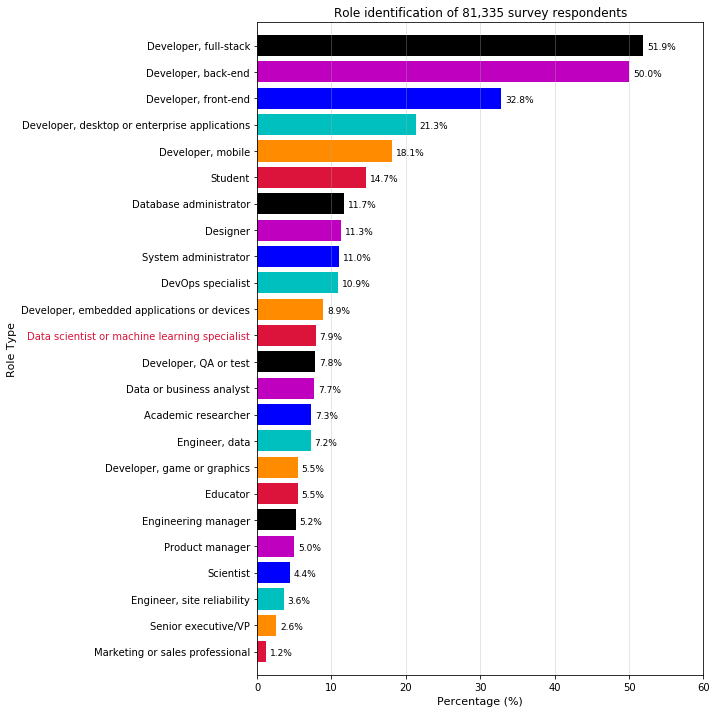

In [12]:
# Display horizontal bar chart of DevType role identification for all survey respondents
title_text = f'Role identification of {len(survey):,} survey respondents'
fig, ax = return_series_barh(role_type_pct, title_text)
ax.set_xticks(list(range(0,70,10)))
ax.get_yticklabels()[11].set_color('crimson')
ax.set_ylabel('Role Type', fontsize=fs+1) ;

In [13]:
# Subset survey data to repondents who identified as a 'Data scientist or machine learning specialist'
ds_role_title = 'Data scientist or machine learning specialist'
ds_survey = survey[survey[ds_role_title]==1]

# Calculate percentage of Data Scientists identifying with each role
ds_role_type_pct = round(100*ds_survey[role_cols].sum()/len(ds_survey),1).sort_values(ascending=False)
ds_role_type_pct

Data scientist or machine learning specialist    100.0
Developer, back-end                               47.6
Developer, full-stack                             37.8
Data or business analyst                          32.2
Academic researcher                               29.0
Engineer, data                                    29.0
Scientist                                         23.9
Student                                           23.4
Developer, front-end                              22.1
Database administrator                            19.5
Developer, desktop or enterprise applications     19.5
System administrator                              14.1
Developer, mobile                                 14.0
Designer                                          13.2
DevOps specialist                                 12.7
Educator                                          11.9
Developer, embedded applications or devices       11.8
Developer, QA or test                              8.6
Product ma

Since this data has been subset on respondents that identify with the 'Data scientist or machine learning specialist' DevType role, the percentage of respondents for this role in the results above is 100%.

For a more informative measure, let's calculate respondents who identified as a 'Data scientist or machine learning specialist' **ONLY**, and replace this value with this measure.

In [14]:
# Create list of DevType roles, exluding the 'Data scientist or machine learning specialist' role
non_ds_role_cols = [role for role in role_cols if role != ds_role_title]

# Calculate number of respondents who identified as a 'Data scientist or machine learning specialist' ONLY
ds_only_num = ds_survey[ds_survey[non_ds_role_cols].eq(0).all(axis=1)].shape[0]

# Calculate this as a percentage of all respondents who identified with this role and replace the 100% 
# value in the series above
ds_role_type_pct.loc[ds_role_title] = round(100 * ds_only_num / len(ds_survey), 1)
ds_role_type_pct.sort_values(ascending=False, inplace=True)
ds_role_type_pct

Developer, back-end                              47.6
Developer, full-stack                            37.8
Data or business analyst                         32.2
Engineer, data                                   29.0
Academic researcher                              29.0
Scientist                                        23.9
Student                                          23.4
Developer, front-end                             22.1
Database administrator                           19.5
Developer, desktop or enterprise applications    19.5
System administrator                             14.1
Developer, mobile                                14.0
Designer                                         13.2
DevOps specialist                                12.7
Educator                                         11.9
Developer, embedded applications or devices      11.8
Developer, QA or test                             8.6
Data scientist or machine learning specialist     8.1
Product manager             

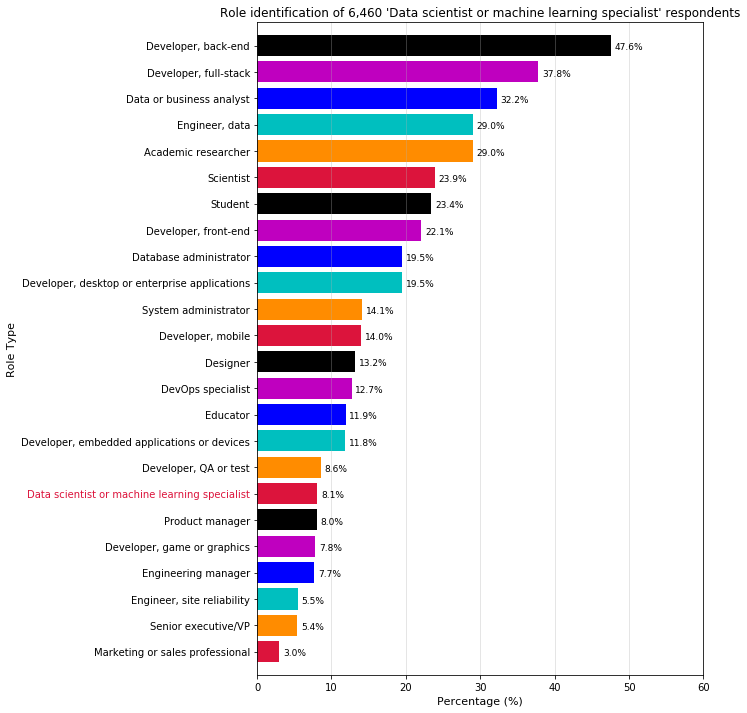

In [15]:
# Display horizontal bar chart of of DevType role identification for survey respondents
# who identified as a 'Data scientist or machine learning specialist'.
# Note the percentage assigned to 'Data scientist or machine learning specialist' is the
# percentgae of respondents who identify with this role only
title_text = f'Role identification of {len(ds_survey):,} \'{ds_role_title}\' respondents'
fig, ax = return_series_barh(ds_role_type_pct, title_text)
ax.set_xticks(list(range(0,70,10)))
ax.get_yticklabels()[17].set_color('crimson')
ax.set_ylabel('Role Type', fontsize=fs+1) ;

It will be interesting to compare the 2 charts above side-by-side.

In [16]:
# Concatenate role type percentages for all survey respondents and DS specialists
role_pct = pd.concat([role_type_pct, ds_role_type_pct], axis=1)
role_pct.columns=['all_respondents', 'ds_respondents']
role_pct

,all_respondents,ds_respondents
"Developer, full-stack",51.9,37.8
"Developer, back-end",50.0,47.6
"Developer, front-end",32.8,22.1
"Developer, desktop or enterprise applications",21.3,19.5
"Developer, mobile",18.1,14.0
Student,14.7,23.4
Database administrator,11.7,19.5
Designer,11.3,13.2
System administrator,11.0,14.1
DevOps specialist,10.9,12.7


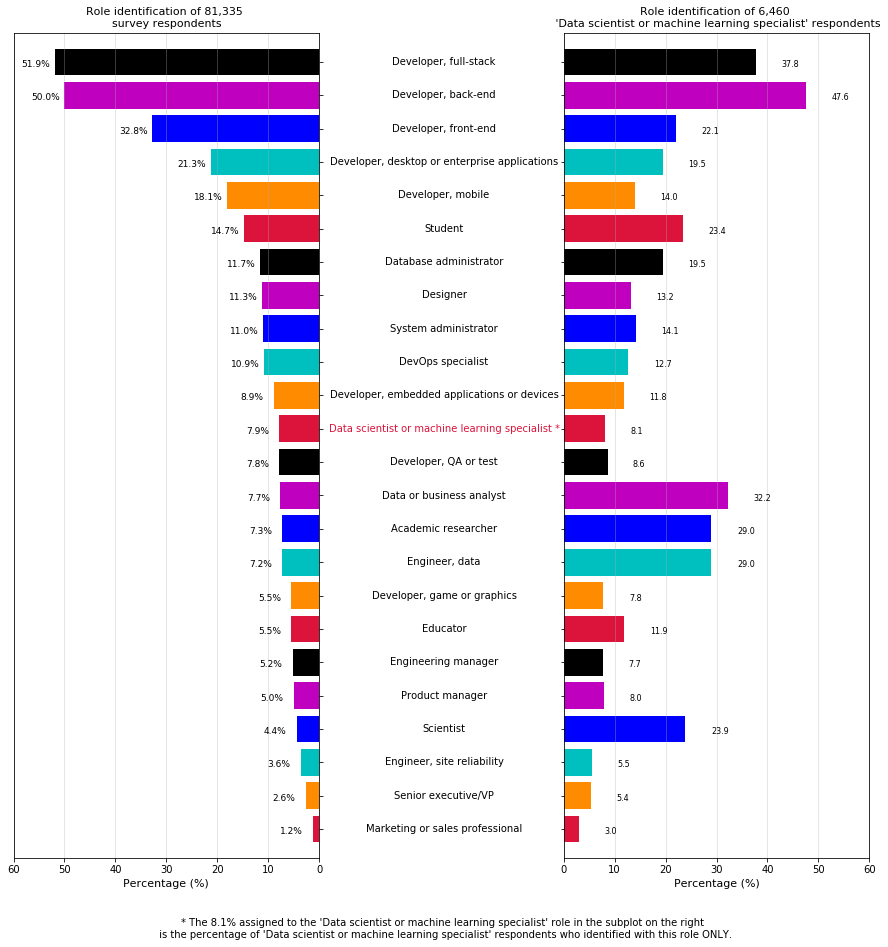

In [17]:
# Generate side-by-side comparison of above bar charts
fig, ax = return_adjacent_barh(role_pct, 'all_respondents', 'ds_respondents', highlight_text=True)

# Configure figure, axes and titles
ax[0].set_xticks(list(range(0,70,10)))
ax[0].set_xlabel('Percentage (%)', fontsize=fs+1)
ax[0].set_title(f'Role identification of {len(survey):,} \nsurvey respondents', fontsize=fs+1)
fig.subplots_adjust(wspace=0.8)

ax[1].set_xticks(list(range(0,70,10)))
ax[1].set_xlabel('Percentage (%)', fontsize=fs+1)
ax[1].set_title(f'Role identification of {len(ds_survey):,} \n \'{ds_role_title}\' '
                f'respondents', fontsize=fs+1) 

# Add figure footnote to explain the measure for the DS role in the subplot on the right hand side
ds_role_only = f'{role_pct.loc[ds_role_title, "ds_respondents"]}%'
footnote_text = f'* The {ds_role_only} assigned to the \'{ds_role_title}\' role in the subplot ' \
                f'on the right \n is the percentage of \'{ds_role_title}\' ' \
                f'respondents who identified with this role ONLY.'

ax[0].annotate(footnote_text, (0.5, 26), xycoords=('figure fraction', 'data'),
                     ha='center', va='center', fontsize=fs) ;

## Observations

Of the 81,335 survey respondents who specified a Development-type role that they identified with, just 7.9% of respondents identified as a 'Data scientist or machine learning specialist'.  As a Data Scientist, this was surprisingly low to me.  To derive meaningful insights from responses provided by Data Scientists, this highlights the importance of analysing survey responses that have been provided by this minority of the survey sample.

When looking at the 7.8% of survey respondents who identified as a 'Data scientist or machine learning specialist', just 8.1% of these identified as a 'Data scientist or machine learning specialist' ONLY - with the remaining 91.9% identifying as 'Data scientist or machine learning specialist' as well as at least 1 additional role.  Again, I was surprised by this and it highlights the multi-faceted nature of the Data Scientist (DS) role.  The 5 top roles that DS specialists also identified with were:

1. Developer, back-end: 47.6%
2. Developer, full-stack: 37.8%
3. Data or business analyst: 32.2%
4. Academic researcher: 29.0%
4. Engineer, Data: 29.0%



# Understanding Data Scientists' current job satisfaction

## Q2: How satisfied are Data Scientists with their current job?

### Data understanding, preparation and visualisation

In [18]:
# Filter survey data on Data Scientist respondents who provided a JobSat and OrgSize response
ds_sat_org = survey[(survey.JobSat.notnull()) & (survey.OrgSize.notnull()) \
                     & (survey[ds_role_title]==1)]

# How many rows of data do we have to work with?
len(ds_sat_org)

5222

In [19]:
# Create lists to order org size and job satisfaction ratings for visuals
org_size_order_list = ['Just me - I am a freelancer, sole proprietor, etc.', '2-9 employees', \
                       '10 to 19 employees', '20 to 99 employees', '100 to 499 employees', \
                       '500 to 999 employees', '1,000 to 4,999 employees', \
                       '5,000 to 9,999 employees', '10,000 or more employees']

job_sat_order_list = ['Very satisfied', 'Slightly satisfied', 'Neither satisfied nor dissatisfied', \
                       'Slightly dissatisfied', 'Very dissatisfied']

# Calculate number of DS for each JobSat rating for each OrgSize
ds_sat_org = ds_sat_org.groupby(['OrgSize','JobSat']).size().unstack()

# Order data for visual analysis
ds_sat_org = ds_sat_org.reindex(index=org_size_order_list)
ds_sat_org = ds_sat_org.reindex(columns=job_sat_order_list)
ds_sat_org.index.name=''

# Calculate org_size totals and percentage of respondents for each org size
ds_sat_org['total'] = ds_sat_org.sum(axis=1)
ds_sat_org['total_pct'] = round(100*ds_sat_org.total / ds_sat_org.total.sum(),1)
ds_sat_org

JobSat,Very satisfied,Slightly satisfied,Neither satisfied nor dissatisfied,Slightly dissatisfied,Very dissatisfied,total,total_pct
,,,,,,,
"Just me - I am a freelancer, sole proprietor, etc.",110,76,71,38,25,320,6.1
2-9 employees,247,176,58,66,34,581,11.1
10 to 19 employees,168,162,74,44,36,484,9.3
20 to 99 employees,315,325,109,122,56,927,17.8
100 to 499 employees,271,277,89,102,55,794,15.2
500 to 999 employees,103,118,25,36,21,303,5.8
"1,000 to 4,999 employees",203,199,64,74,45,585,11.2
"5,000 to 9,999 employees",97,102,30,31,18,278,5.3
"10,000 or more employees",328,301,94,157,70,950,18.2


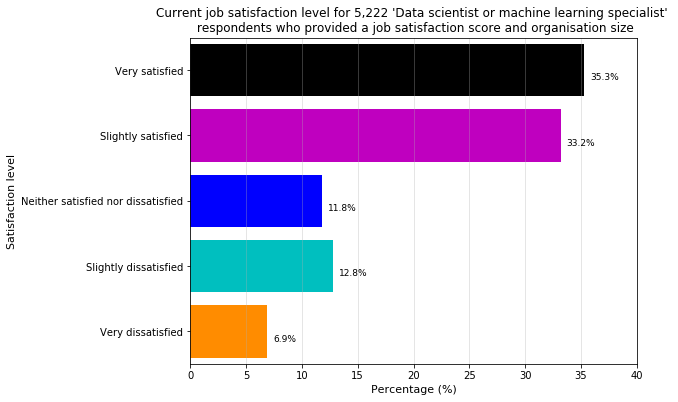

In [20]:
# For DSs, caclculate percentage of repondents for each satisfaction rating and plot
# as a horizontal bar chart
ds_sat_pct = round(100 * ds_sat_org[job_sat_order_list].sum() / ds_sat_org.total.sum(), 1)
title_text = f'Current job satisfaction level for {ds_sat_org.total.sum():,} \'{ds_role_title}\' \n ' \
             f'respondents who provided a job satisfaction score and organisation size'
    
fig, ax = return_series_barh(ds_sat_pct, title_text)
ax.set_xticks(list(range(0,41,5)))
ax.set_ylabel('Satisfaction level', fontsize=fs+1) 
fig.set_size_inches(8, 6);

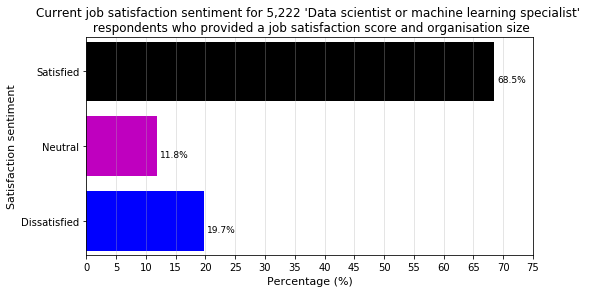

In [21]:
# Calculate satisfaction 'sentiment': Satisfied, Neutral, Dissatisified and plot
ds_sat_pct_sent = [ds_sat_pct['Very satisfied'] + ds_sat_pct['Slightly satisfied'], \
                   ds_sat_pct['Neither satisfied nor dissatisfied'],
                 ds_sat_pct['Slightly dissatisfied'] + ds_sat_pct['Very dissatisfied']]
ds_sat_pct_sent = [round(val,1) for val in ds_sat_pct_sent]

ds_sat_pct_sent = pd.Series(ds_sat_pct_sent, index=['Satisfied', 'Neutral', 'Dissatisfied'])
title_text = f'Current job satisfaction sentiment for {ds_sat_org.total.sum():,} \'{ds_role_title}\' \n ' \
             f'respondents who provided a job satisfaction score and organisation size'
    
fig, ax = return_series_barh(ds_sat_pct_sent, title_text)
ax.set_xticks(list(range(0,76,5)))
ax.set_ylabel('Satisfaction sentiment', fontsize=fs+1) 
fig.set_size_inches(8, 4);

### Observations
The results above are a pleasant surprise, with just over 2/3 of survey respondents who identify as a 'Data scientist or machine learning specialist' either very or slightly satisfied with their current job.

Approximately 1 in 5 Data Scientists  is either slightly or very dissatisfied with their current job.

## Q3: How does this job satisfaction vary with company size?

### Data understanding, preparation and visualisation

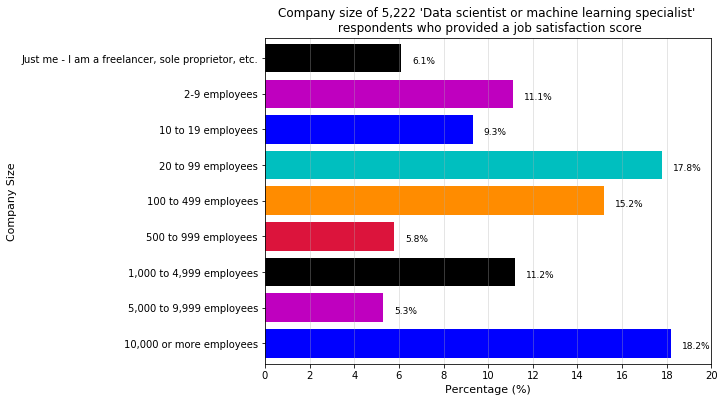

In [22]:
# Plot percentage of DSs working at each company size
title_text = f'Company size of {ds_sat_org.total.sum():,} \'{ds_role_title}\' \n respondents ' \
             f'who provided a job satisfaction score'
fig, ax = return_series_barh(ds_sat_org['total_pct'], title_text)
ax.set_xticks(list(range(0,21,2)))
ax.set_ylabel('Company Size', fontsize=fs+1) 
fig.set_size_inches(8, 6);

In [23]:
# Convert job satisfaction numbers to percentage of those working at each company size
for col_name in job_sat_order_list:
    ds_sat_org[col_name] = round(100 * ds_sat_org[col_name] / ds_sat_org.total, 1)
ds_sat_org

JobSat,Very satisfied,Slightly satisfied,Neither satisfied nor dissatisfied,Slightly dissatisfied,Very dissatisfied,total,total_pct
,,,,,,,
"Just me - I am a freelancer, sole proprietor, etc.",34.4,23.8,22.2,11.9,7.8,320,6.1
2-9 employees,42.5,30.3,10.0,11.4,5.9,581,11.1
10 to 19 employees,34.7,33.5,15.3,9.1,7.4,484,9.3
20 to 99 employees,34.0,35.1,11.8,13.2,6.0,927,17.8
100 to 499 employees,34.1,34.9,11.2,12.8,6.9,794,15.2
500 to 999 employees,34.0,38.9,8.3,11.9,6.9,303,5.8
"1,000 to 4,999 employees",34.7,34.0,10.9,12.6,7.7,585,11.2
"5,000 to 9,999 employees",34.9,36.7,10.8,11.2,6.5,278,5.3
"10,000 or more employees",34.5,31.7,9.9,16.5,7.4,950,18.2


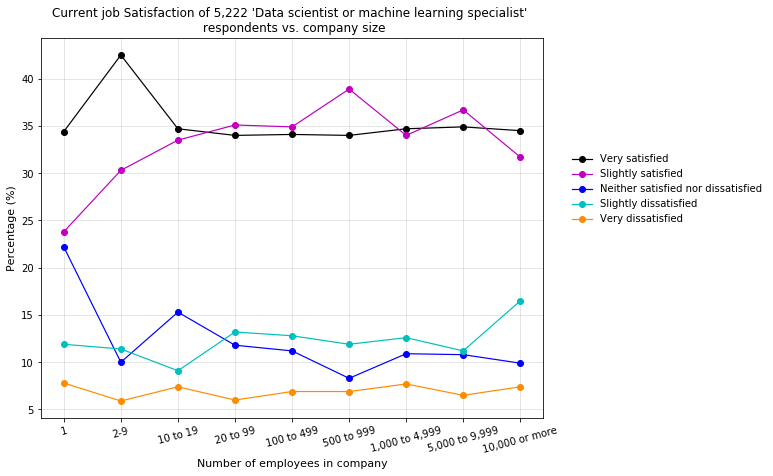

In [24]:
# Generate line plots of satisfaction rating percentages vs company size
title_text = f'Current job Satisfaction of {ds_sat_org.total.sum():,} \'{ds_role_title}\' \n respondents ' \
             f'vs. company size'
fig, ax = return_line_plot(ds_sat_org, title_text, job_sat_order_list)

# Configure plot
labels = [val.strip('employees').strip() if 'employees' in val else '1' for val in list(ds_sat_org.index)]
ax.set_xticklabels(labels, rotation=15)
ax.set_xlabel('Number of employees in company', fontsize=fs+1) ;

### Observations
Again, the analysis of the proportion of Data Scientists across the range of company sizes is a surprise to me.  The most common sized companies for Data Scientists are either large companies with more than 10,000 employees or quite small companies with between 20 and 99 employees. This perhaps reflects the investment that large organisations are making into Data Science and Machine Learning as well as the proliferation of start-ups that are employing Data Scientists.  The proportion of Data Scientists employed by medium-sized companies is notably lower, as is the proportion of freelance (6.1%) Data Scientists.

When looking at the job satisfaction percentages of Data Scientists across the range of company sizes, the first jump-out is that Data Scientists are generally satisfied across all company sizes, with a notable drop-off for those that are freelancing.  There is also a drop-off in overall satisfaction at the largest companies, coinciding with a peak in those who are slightly dissatisfied.  An additional point to note, is the peak in the highest satisfaction rating at small companies with between 2 and 9 employees.  This increase in satisfaction appears to be at the expense of those who are slightly satisfied or neutral about their job, rather than those who are dissatisfied.





## Q4: How does this job satisfaction vary with manager confidence?

### Data understanding, preparation and visualisation

In [25]:
# Filter on Data Scientist respondents who provided a JobSat and MgrIdiot response
ds_sat_mgr=survey[(survey.JobSat.notnull()) & (survey.MgrIdiot.notnull()) \
                   & (survey[ds_role_title]==1)]

# Calculate how many respondents for each job satisfcation rating grouped by company size
ds_sat_mgr=ds_sat_mgr.groupby(['MgrIdiot','JobSat']).size().unstack()
ds_sat_mgr=ds_sat_mgr.reindex(columns=job_sat_order_list)
ds_sat_mgr.index.name=''
ds_sat_mgr['total'] = ds_sat_mgr.sum(axis=1)

# Convert actual number of respondents to percentages for each manager confidence rating
for col in job_sat_order_list:
    ds_sat_mgr.loc[:,col] = round(100* ds_sat_mgr.loc[:,col] / ds_sat_mgr.total, 1)

# Display data
ds_sat_mgr

JobSat,Very satisfied,Slightly satisfied,Neither satisfied nor dissatisfied,Slightly dissatisfied,Very dissatisfied,total
,,,,,,
I don't have a manager,42.5,27.5,12.4,8.5,9.2,153
Not at all confident,10.1,30.1,16.6,27.6,15.6,692
Somewhat confident,24.0,42.3,14.6,14.6,4.6,1759
Very confident,53.9,28.5,5.9,6.5,5.2,1735


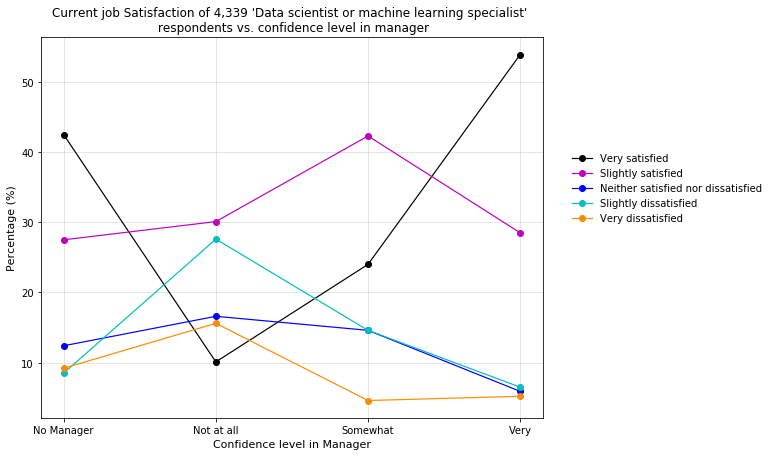

In [26]:
# Generate line plots of satisfaction rating percentages vs. manager confidence
title_text = f'Current job Satisfaction of {ds_sat_mgr.total.sum():,} \'{ds_role_title}\' \n respondents ' \
             f'vs. confidence level in manager'
fig, ax = return_line_plot(ds_sat_mgr, title_text, job_sat_order_list)
labels = [val.strip('confident').strip() if 'confident' in val else 'No Manager' for val in list(ds_sat_mgr.index)]
ax.set_xticklabels(labels, rotation=0)
ax.set_xlabel('Confidence level in Manager', fontsize=fs+1) ;

### Observations
The old saying that confidence in your Manager (largely synonymous with 'a good Manager') is critical to employee satisfaction  clearly holds true for Data Scientists. 82.4% of Data Scientists that are very confident in their Manager's capabilities are either very or slightly satisfied with their current job.  The combined incidence of very and slightly satisfied Data Scientists is more than halved for those that do not have confidence in their Manager, with just 1 in 10 Data Scientists saying they are very satisfied with their job, while having no confidence in their Manager's capabilities.

For those that have no confidence in their Manager, 43.2% of Data Scientists are either slightly or very dissatisfied with their job.  Interestingly, 70.0% of Data Scientists without a Manager are either very or slightly satisfied with their job.

# Q5: How does compensation vary by country for the 10 most common countries?

### Data understanding, preparation and visualisation

In [27]:
# Create dataframe of the country of residence and converted compensation of DSs
cols_to_keep = ['Country', 'ConvertedComp']
ds_comp_ctry = survey[(survey.Country.notnull()) & (survey[ds_role_title]==1) & \
                      (survey.ConvertedComp.notnull())][cols_to_keep]

# Identity 10 countries with the most data rows
top_10_ctry_list = list(ds_comp_ctry.groupby(['Country']).size().\
                        sort_values(ascending=False).head(10).index)

# Filter data by top 10 countries
ds_comp_ctry = ds_comp_ctry[ds_comp_ctry.Country.isin(top_10_ctry_list)].reset_index(drop=True)
ds_comp_ctry.head()

,Country,ConvertedComp
0,Canada,366420.0
1,India,13293.0
2,Netherlands,87994.0
3,Germany,137490.0
4,United States,66750.0


In [28]:
# Display the percentage share of responses across these 10 countries
round(100 * ds_comp_ctry.groupby(['Country']).size() / \
      len(ds_comp_ctry), 2).sort_values(ascending=False)

Country
United States     44.93
Germany           10.76
India             10.11
United Kingdom     9.41
Canada             5.56
France             4.33
Netherlands        4.25
Brazil             3.89
Spain              3.64
Australia          3.13
dtype: float64

In [29]:
# For each country remove outliers based on Tukey method
ds_comp_ctry_filtered = pd.DataFrame(columns=['Country','ConvertedComp','Median'])

# Create dictionary to store upper and lower outlier ranges for future analysis
tukey_ranges = {}
for country in top_10_ctry_list:
    country_comp = ds_comp_ctry[ds_comp_ctry.Country==country]
    q3 = country_comp.ConvertedComp.quantile(q=0.75)
    q1 = country_comp.ConvertedComp.quantile(q=0.25)
    upper_limit = q3 + 1.5*(q3-q1)
    lower_limit = q1 - 1.5*(q3-q1)
    
    # Store upper and lower limits per country for future analysis
    tukey_ranges[country] ={'lower_limit':lower_limit, 'upper_limit':upper_limit}
    
    # Remove outliers based on the Tukey method
    outlier_mask = ((country_comp.ConvertedComp>upper_limit) | (country_comp.ConvertedComp<lower_limit))
    country_comp = country_comp[~outlier_mask]
    
    # Insert Median columns to help with sorting of country boxplots
    median_sal = country_comp.ConvertedComp.median()
    country_comp['Median'] = median_sal
    print(f'Medium salary of {country} is ${round(median_sal)}')
    ds_comp_ctry_filtered = ds_comp_ctry_filtered.append(country_comp)

# Sort resulting dataframe by Median and display results
ds_comp_ctry_filtered.sort_values(by='Median', ascending=False, inplace=True)

Medium salary of United States is $110000
Medium salary of Germany is $60725
Medium salary of India is $10774
Medium salary of United Kingdom is $65424
Medium salary of Canada is $65040
Medium salary of France is $44684
Medium salary of Netherlands is $54996
Medium salary of Brazil is $16062
Medium salary of Spain is $31794
Medium salary of Australia is $72530


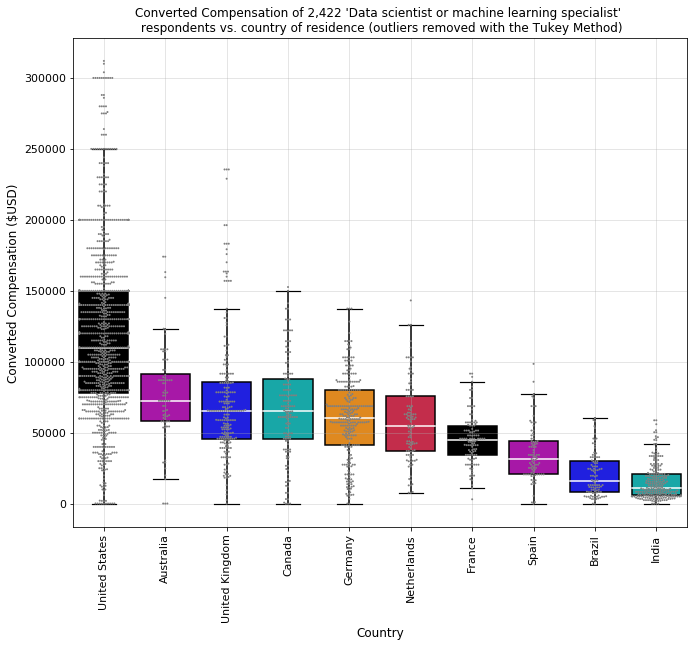

In [30]:
# Generate box and swarm plot of DS converted compensation by country
comp_ctry_boxplot(ds_comp_ctry_filtered)

### Observations
The first thing to note are the 10 countries that had the most Data Scientists providing their salary in the survey.  The US had the most responses by far (44.9\%), 4 times that of the next country - Germany (10.8\%).  India and the United Kingdom had the next highest number of responses, with 10.1\% and 9.4\% respectively.

Note, the analysis above has outlier salary figures removed using the Tukey method.  Salaries are converted to USD and will therefore be subject to exchange rates.

The order of the median salaries for these countries has a relative wide range. The US has the highest median salary at \\$110,000, as well as the widest interquartile range.  The US's median salary for their Data Scientists is 51.7\% higher than the next country (Australia) and 81.1\% higher than the country with the second highest number of Data Scientists reporting salaries (Germany). At the opposite end of the spectrum, India's median Data Scientist salary is \\$10,744 - just 9.8% of the US median salary.

# Q6: How often to Data Scientists visit Stack Overflow?

## Data understanding, preparation and visualisation

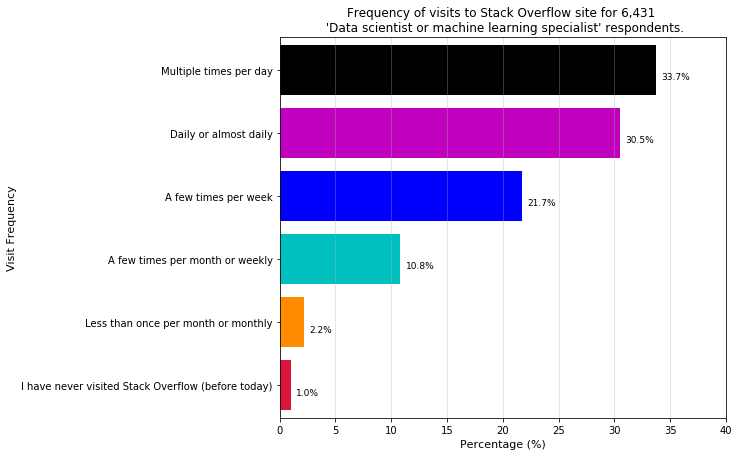

In [31]:
# Filter on Data Scientist respondents who provided SOVisitFreq response
ds_so_visit=survey.loc[(survey.SOVisitFreq.notnull()) & (survey[ds_role_title]==1),['SOVisitFreq']]

# Group data by SOVisitFreq response and calculate percentages for each response
ds_so_visit_pct = round(100 * ds_so_visit.groupby(['SOVisitFreq']).size() / \
                        len(ds_so_visit),1).sort_values(ascending=False)

# Generate horzontal bar chart of DS Stack Overflow visit frequency
title_text = f'Frequency of visits to Stack Overflow site for {len(ds_so_visit):,} \n '\
             f'\'{ds_role_title}\' respondents.'

fig, ax = return_series_barh(ds_so_visit_pct, title_text)
ax.set_xticks(list(range(0,41,5)))
ax.set_ylabel('Visit Frequency', fontsize=fs+1) 
fig.set_size_inches(8, 7);

## Observations
Almost 2 in 3 (64.2%) of the 6,431 Data Scientists who responded to the question regarding how often they visit Stack Overflow visit the site daily, with 33.7% visiting the site multiple times per day. 85.9% of Data Scientists visit the site at least a few times per week, with just 2.2% visiting the site monthly or less than once per month.

Only 1.0% of Data Scientists had never visited the site before completing this survey - which isn't surprising as you're unlikely to know about the survey if you don't visit it!

# Understanding Data Scientists' programming tool kit?

## Q7: What are the most common programming languages for Data Scientists in the US, Australia, UK and Canada?

### Data understanding, preparation and visualisation

In [32]:
# Create Dataframe of DataScientists who provided a ConvertedComp and LanguageWorkedWith response,
# and was located in a subset of specified countries
cols_to_keep = ['LanguageWorkedWith', 'JobSat', 'ConvertedComp', 'Country']
ctrys_to_keep = ['United States', 'Australia', 'United Kingdom', 'Canada', 'Germany']
ds_lang=survey[(survey[ds_role_title]==1) & (survey.LanguageWorkedWith.notnull()) & \
               (survey.ConvertedComp.notnull()) & (survey.Country.isin(ctrys_to_keep))][cols_to_keep]

# Split the LanguageWorkedWith column values into multiple value-specific columns
ds_lang, lang_list_cols = split_col_vals(ds_lang,'LanguageWorkedWith')
ds_lang.drop(columns=['LanguageWorkedWith'], inplace=True)
ds_lang.reset_index(drop=True, inplace=True)

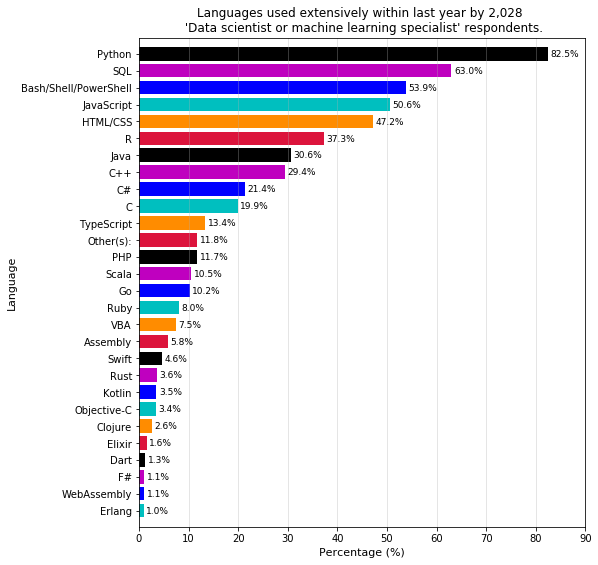

In [33]:
# Calcule percentage of Data Sceientists with each language
ds_lang_pct = round(100 * ds_lang[lang_list_cols].sum().sort_values(ascending=False) / len(ds_lang), 1)

# Generate horzontal bar chart of DS programming language percentages
title_text = f'Languages used extensively within last year by {len(ds_lang):,} \n '\
             f'\'{ds_role_title}\' respondents.'

fig, ax = return_series_barh(ds_lang_pct, title_text)
ax.set_xticks(list(range(0,91,10)))
ax.set_ylabel('Language', fontsize=fs+1) 
fig.set_size_inches(8, 9);

### Observations
82.5\% of Data Scientists in the USA, Australia, UK, Canada or Germany have used Python extensively for development over the last 12 months.  SQL (63.0\%), Bash/Shell/PowerShell (53.9\%), JavaScript (50.6\%) and HTML/CSS (47.2\%) rounded out the top 5 most common skills.  The appearance of JavaScript in the top 5 was a surprise to me.  I was also surprised that R was so much less common than Python, with less than half the number of Data Scientists using R extensively compared with Python.

Note, the reason for subseting on these 5 countries was because I also wanted to investigate how these programming skills relate to pay.

## Q8: How are these programming skills related to mean converted compensation?

### Data understanding, preparation and visualisation

In [34]:
# Remove converted compensation outliers as determined with Tukey method above
ds_lang_filtered = []
for country in ds_lang.Country.unique():
    upper_limit = tukey_ranges[country]['upper_limit']
    lower_limit = tukey_ranges[country]['lower_limit']
    mask = (ds_lang.Country==country) & (ds_lang.ConvertedComp<=upper_limit) & \
           (ds_lang.ConvertedComp>=lower_limit)
    ds_lang_filtered.append(ds_lang[mask])   
ds_lang = pd.concat(ds_lang_filtered)
ds_lang.reset_index(drop=True)

# Calculate mean ConvertedComp for each programming language, with outliers removed 
ds_lang_comp = pd.DataFrame(columns=['Language', 'Mean_ConvertedComp'])
for (i, lang_col) in enumerate(lang_list_cols):
    ds_lang_sub = ds_lang[ds_lang[lang_col]==1.0]
    ds_lang_comp.loc[i] = [lang_col, round(ds_lang_sub.ConvertedComp.mean()/1000) ]
ds_lang_comp.set_index('Language', inplace=True)

# Merge mean compensation with DS percentage figures
ds_lang_df = pd.merge(ds_lang_comp, ds_lang_pct.to_frame(name='Lang_pct'), \
                      left_index=True, right_index=True, how='outer').sort_values('Lang_pct', ascending=False)

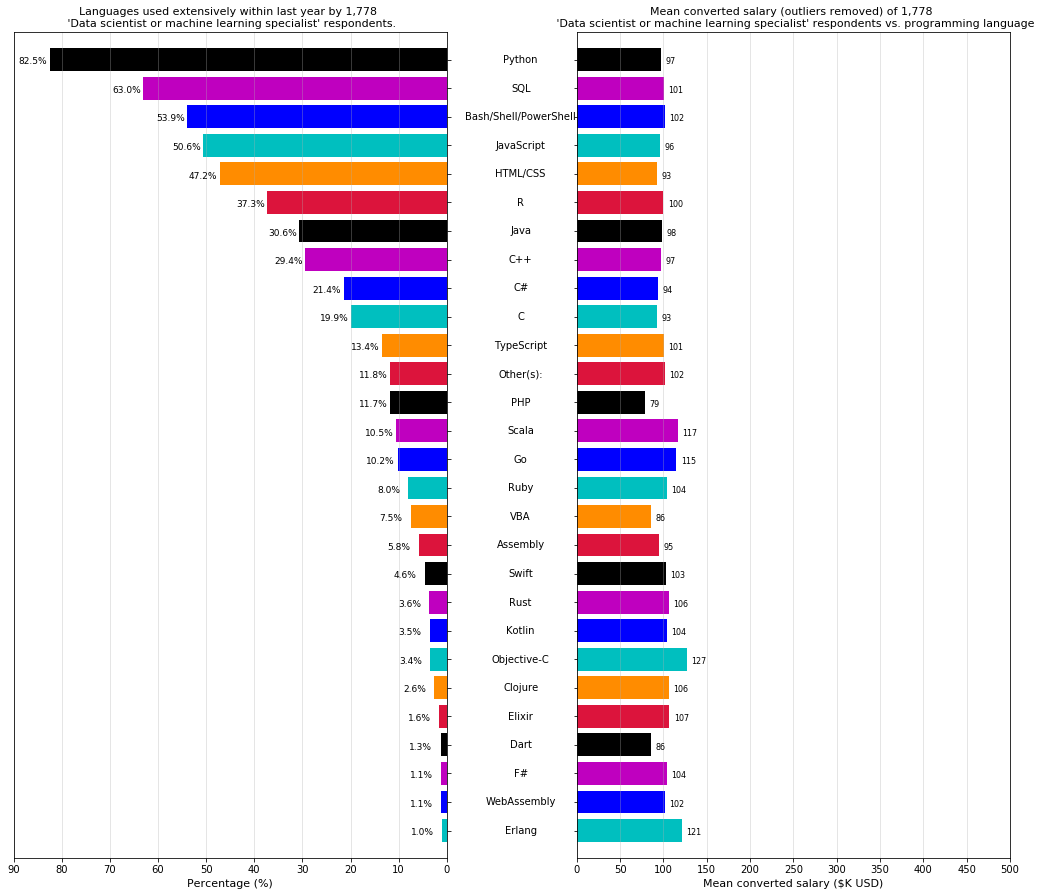

In [65]:
# Generate side-by-side comparison of lanagues used vs mean converted compensation for each language
fig, ax = return_adjacent_barh(ds_lang_df, 'Lang_pct', 'Mean_ConvertedComp')
fig.set_size_inches(14.5, 12)
ax[0].set_xticks(list(range(0,91,10)))
ax[0].set_xlabel('Percentage (%)', fontsize=fs+1)
title_text = f'Languages used extensively within last year by {len(ds_lang):,} \n '\
             f'\'{ds_role_title}\' respondents.'
ax[0].set_title(title_text, fontsize=fs+1)

title_text = f'Mean converted salary (outliers removed) of {len(ds_lang):,} \n \'{ds_role_title}\' ' \
             f'respondents vs. programming language'
ax[1].set_xticks(list(range(0,510,50)))
ax[1].set_xlabel('Mean converted salary ($K USD)', fontsize=fs+1)
ax[1].set_title(title_text, fontsize=fs+1) ;

### Observations
As is to to be expected, the mean converted compensation is generally higher for respondents with recent and extensive  experience in programming languages that are less 'common'. Data Scientists with Objective-C and Erlang are in short supply - with just 3.4% and 1.0% having had extensive development experience with these languages in the past 12 months. This is reflected in the notably higher mean salaries of Data Scientists applying these languages.  There are also notable peaks in the mean salary of Data Scientists with expertise in Scala and Go - with approximately 1 in 10 Data Scientists having  used these languages extensively within the last year.  Salaries are notably lower for Data Scientists with experience in PHP, Dart and VBA.  Of the top 5 most common programming languages, Bash/Shell/PowerShell, SQL, Python, JavaScript, and HTML/CSS ranked 14th, 15th, 20th, 21st and 25th respectively of the 28 programming languages with respect to their mean salary. 

In reality, salaries are heavily influenced by experience in applying a combination of these programming languages, as well as numerous other factors. 

**In reality, experience in a combination of these skills is what drives individual compensation.**

# Understanding drivers for Data Scientists' job satisfaction

## Data understanding, preparation and visualisation

In this next section, I'll attempt to model Data Scientists' current job satisfaction using the features discussed above, as well an additional subset of intuitively selected fields from the survey to understand the relative importance of these features in determining job satisfaction.

In [36]:
# Filter survey data for Data Scientists who provided a JobSat, MgrIdiot, OrgSize, SOVisitFreq
# and LanguageWorkedWith response
model_df = survey[(survey.JobSat.notnull()) & (survey.MgrIdiot.notnull()) & \
                  (survey[ds_role_title]==1) & (survey.OrgSize.notnull()) & \
                  (survey.SOVisitFreq.notnull()) & (survey.LanguageWorkedWith.notnull())]

model_df = model_df.reset_index(drop=True)

# Split LanguageWorkedWith column and display shape of resulting dataframe
model_df, lang_list_cols = split_col_vals(model_df,'LanguageWorkedWith')

model_df.shape


(4181, 137)

In [37]:
# Select columns for modeling and subset model_df on these columnes
model_cols = ['Hobbyist', 'OpenSourcer', 'Employment', 'Country', 'OrgSize', 'YearsCode', \
              'YearsCodePro', 'CareerSat', 'MgrIdiot', 'WorkRemote', 'ImpSyn', 'SOVisitFreq', \
              'JobSat'] + lang_list_cols + role_cols

model_df = model_df[model_cols]

# Print number of null values in these columns where nulls exist
for col in model_cols:
    if model_df[col].isnull().sum() != 0:
        print_null_val_percentage(model_df, col)


0.22% of the YearsCode column is Null.
0.31% of the YearsCodePro column is Null.
0.5% of the WorkRemote column is Null.
0.41% of the ImpSyn column is Null.


In [38]:
# Manage null values in these columns

# Start by viewing value_counts for each col to help determine most appropriate imputation approach
cols_with_nulls = ['WorkRemote', 'ImpSyn', 'YearsCode', 'YearsCodePro']
for col in cols_with_nulls:
    print(col)
    print(model_df[col].value_counts(dropna=False))
    print('-'*100)

WorkRemote
Less than once per month / Never                           1703
A few days each month                                      1231
Less than half the time, but at least one day each week     445
All or almost all the time (I'm full-time remote)           319
It's complicated                                            194
More than half, but not all, the time                       152
About half the time                                         116
NaN                                                          21
Name: WorkRemote, dtype: int64
----------------------------------------------------------------------------------------------------
ImpSyn
A little above average    1883
Far above average         1013
Average                    886
A little below average     289
Far below average           93
NaN                         17
Name: ImpSyn, dtype: int64
----------------------------------------------------------------------------------------------------
YearsCode
10            

In [39]:
# Based on the value counts for the 4 fields above, I'm going to impute missing values
# with the mode of each field.  This is because the number of missing values is relatively 
# small and the modes for these fields are either distinct or make more sense then using 
# the mean value
for col in cols_with_nulls:
    model_df.loc[model_df[col].isnull(),col]=model_df[col].mode()[0]

In [40]:
# Confirm no more missing values
model_df.isnull().sum().sum()

0

## Modeling

In [41]:
# Assign X (features) and y (outcome), and dummify features
y = model_df.JobSat.values
X = model_df.drop(columns=['JobSat'])
X = pd.get_dummies(X, drop_first=True)

# Display resulting shape of predictors dataframe
print(X.shape)

# Split data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

(4181, 295)


I'll start by GridSearching a RandomForestClassifier to try to predict the Job Satisfaction category using the features selected above.

In [42]:
# Instantiate RandomForestClassifier
clf_rf = RandomForestClassifier(random_state=10)

# Define hyperparameter grid
param_grid = {'n_estimators':[10, 50, 75, 100, 200, 300, 500], 
              'criterion':['gini', 'entropy'], 
              'min_samples_split':[2, 3, 4], 
              'max_depth':[20, None]}

# Instantiate GridSearchCV object
clf_rf_gs = GridSearchCV(clf_rf, param_grid, n_jobs=-1, cv=KFold(random_state=10, shuffle=True))

# Fit GridSearchCV object to training data
clf_rf_gs.fit(X_train, y_train)

# Display the best mean cross validated score on the training data
clf_rf_gs.best_score_

0.5768892389370206

Next, I'll try a GradientBoostingClassifier to see if I can improve on the RandomForestClassifier.

In [43]:
# Instantiate GradientBoostingClassifier
clf_gb = GradientBoostingClassifier(random_state=10)

# Define hyperparameter grid
param_grid = {'learning_rate':[0.05, 0.1, 0.5, 0.8],
              'n_estimators':[50, 100, 200],
              'max_depth':[3, 4, 5], 
              'max_features': [None, 'log2']}

# Instantiate GridSearchCV object
clf_gb_gs = GridSearchCV(clf_gb, param_grid, n_jobs=-1, cv=KFold(random_state=10, shuffle=True))

# Fit GridSearchCV object to training data
clf_gb_gs.fit(X_train, y_train)

# Display the best mean cross validated score on the training data
clf_gb_gs.best_score_

0.5806534231790204

In [44]:
# The GradientBoostingClassifier scored slighly better on the training data
# Now, score the best estimator identified through the grid search on the test data to see how the 
# model generalises
clf_gb_gs.best_estimator_.score(X_test, y_test)

0.5824701195219123

The model has generalised well to the test data, despite the relatively large number of predictors for the number of rows in the dataset.  To assess its predictive capability, let's compare this model's accuracy to that of the baseline model (i.e. selecting the majority class for every row of the JobSat field.

In [45]:
print(f'Baseline model accuracy: {max(pd.Series(y_test).value_counts())/len(y_test)}')

Baseline model accuracy: 0.3601593625498008


The model above is better than the baseline model and demonstrates predictive capability.

In [46]:
# Let's examine the 15 most important predictors in the model
feature_imp = pd.DataFrame({'feature': X_train.columns, 'importance': clf_gb_gs.best_estimator_.feature_importances_})
feature_imp = feature_imp.sort_values(by='importance', ascending=False).set_index('feature').head(15)
feature_imp

,importance
feature,
CareerSat_Very satisfied,0.349393
CareerSat_Slightly satisfied,0.132228
CareerSat_Slightly dissatisfied,0.092354
CareerSat_Very dissatisfied,0.062199
MgrIdiot_Very confident,0.061663
MgrIdiot_Not at all confident,0.038207
Country_India,0.009683
MgrIdiot_Somewhat confident,0.007087
"OrgSize_10,000 or more employees",0.004792


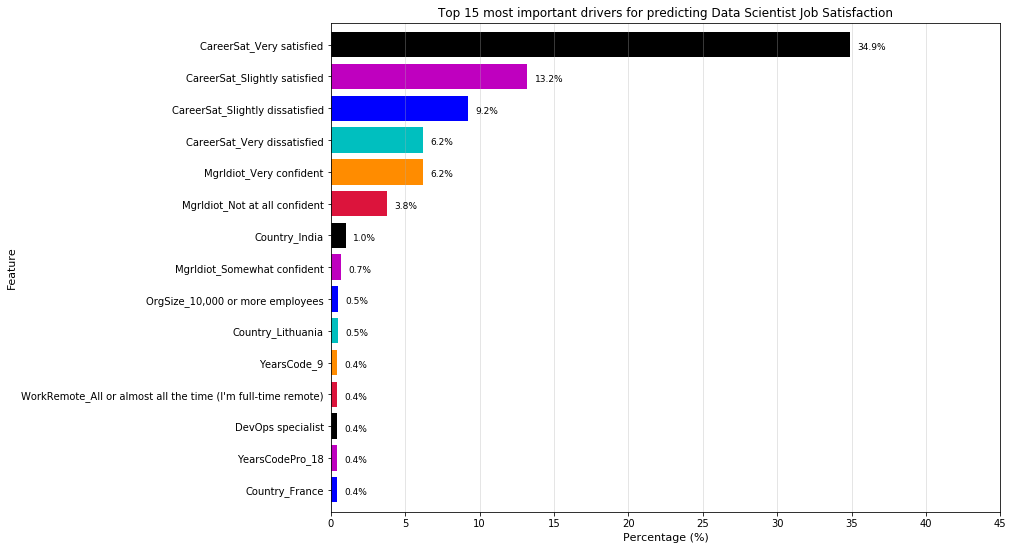

In [47]:
# Let's visualise the 15 most important features / drivers
# Generate horzontal bar chart of DS programming language percentages
title_text = f'Top 15 most important drivers for predicting Data Scientist Job Satisfaction'

fig, ax = return_series_barh(round(feature_imp.importance*100, 1), title_text)
ax.set_xticks(list(range(0,50,5)))
ax.set_ylabel('Feature', fontsize=fs+1) 
fig.set_size_inches(12, 9);

## Observations
Perhaps not surprisingly, Career Satisfaction and Manager Confidence are by the far the strongest drivers for Data Scientist's Job Satisfaction.  Although a lot less important, Organisation size, years of coding experience, working fully remote and 3 countries (India, Lithuania and France) feature in the 15 most important drivers.